In [26]:
import MetaTrader5 
import pandas as pd
import pandas_ta as ta
from datetime import datetime
import pytz
import os
mt5 = MetaTrader5
SYMBOL = "AUDCAD"
TIMEFRAME = mt5.TIMEFRAME_H1
TOTAL_CANDLES = 600

timezone = pytz.timezone('Etc/UTC')
START_DATE =datetime(2025, 6, 1, tzinfo=timezone)
END_DATE =datetime(2025, 12, 1, tzinfo=timezone)


# inisialisasi ke MetaTrader 5
if not mt5.initialize():
    print(f"Connection failed : {mt5.last_error()}")
    quit()

# Pengambilan data dan pembersihan kolom yang tidak diperlukan 
rates = mt5.copy_rates_range(SYMBOL, TIMEFRAME, START_DATE, END_DATE)
mt5.shutdown()
df = pd.DataFrame(rates)
df.drop(columns=['spread', 'real_volume'], inplace=True) # <<<<<< Kolom yang tidak diperlukan
df['time'] = pd.to_datetime(df['time'], unit='s') # merubah waktu delam bentuk standart agar bisa digunakan

df.rename(columns={'time': 'Time','open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'tick_volume': 'Volume'}, inplace=True) # Stabdarisasi nama kolom
# df.to_csv(f'{SYMBOL}.csv', index=False)
df.head(10)

,Time,Open,High,Low,Close,Volume
0,2025-06-02 00:00:00,0.88335,0.88376,0.88314,0.88329,273
1,2025-06-02 01:00:00,0.88329,0.88478,0.88315,0.88478,1832
2,2025-06-02 02:00:00,0.88478,0.88510,0.88427,0.88430,1759
3,2025-06-02 03:00:00,0.88430,0.88580,0.88429,0.88562,3476
4,2025-06-02 04:00:00,0.88562,0.88717,0.88552,0.88578,3809
5,2025-06-02 05:00:00,0.88580,0.88676,0.88559,0.88571,3032
6,2025-06-02 06:00:00,0.88571,0.88594,0.88465,0.88529,2501
7,2025-06-02 07:00:00,0.88529,0.88590,0.88504,0.88578,2148
8,2025-06-02 08:00:00,0.88578,0.88626,0.88550,0.88605,2419
9,2025-06-02 09:00:00,0.88605,0.88682,0.88568,0.88602,3103


In [27]:
df = pd.read_csv(f'{SYMBOL}.csv', index_col='Time')

df.ta.sma(length=20, append=True)
df.ta.sma(length=50, append=True)
df.ta.sma(length=100, append=True)
df.dropna(inplace=True)
df

,Open,High,Low,Close,Volume,SMA_20,SMA_50,SMA_100
Time,,,,,,,,
2025-06-06 03:00:00,0.88970,0.89038,0.88932,0.88951,2924,0.889335,0.888335,0.887883
2025-06-06 04:00:00,0.88951,0.88990,0.88852,0.88865,3131,0.889382,0.888376,0.887937
2025-06-06 05:00:00,0.88865,0.88869,0.88744,0.88774,2749,0.889381,0.888411,0.887966
2025-06-06 06:00:00,0.88774,0.88828,0.88769,0.88818,2566,0.889361,0.888425,0.888005
2025-06-06 07:00:00,0.88818,0.88857,0.88796,0.88846,1913,0.889347,0.888461,0.888033
...,...,...,...,...,...,...,...,...
2025-11-28 20:00:00,0.91548,0.91566,0.91515,0.91515,2268,0.915846,0.915952,0.914274
2025-11-28 21:00:00,0.91515,0.91550,0.91514,0.91524,2370,0.915774,0.915958,0.914313
2025-11-28 22:00:00,0.91524,0.91545,0.91499,0.91521,5217,0.915678,0.915957,0.914356


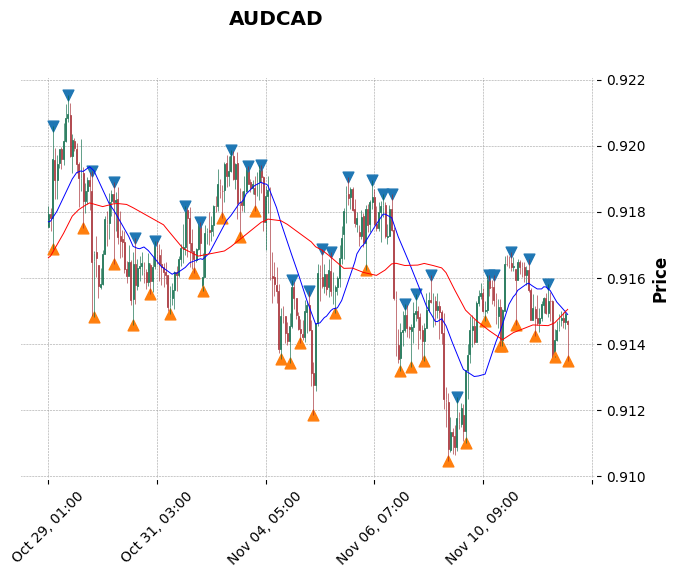

In [ ]:
import mplfinance
import time 

mpf = mplfinance

df = pd.read_csv(f'{SYMBOL}.csv', index_col='Time')
df.ta.sma(length=20, append=True)
df.ta.sma(length=50, append=True)
df.dropna(inplace=True)

def detect_swings(df, window=3):
    df['swing_high'] = df['High'][
        df['High'] == df['High'].rolling(window*2+1, center=True).max()
    ]
    
    df['swing_low'] = df['Low'][
        df['Low'] == df['Low'].rolling(window*2+1, center=True).min()
    ]
    
    return df
detect_swings(df)

df.index = pd.to_datetime(df.index)

def simulasi_loop(df):
    i = 1
    df_start = df
    for i in range(0,200,5):
        df = df_start.iloc[2520+i:2560+i:]
        add = [
            mpf.make_addplot(df['SMA_20'], color='blue', width= 0.7),
            mpf.make_addplot(df['SMA_50'], color='red', width= 0.7),
            mpf.make_addplot(df['swing_high'], type='scatter', marker='v', markersize=60),
            mpf.make_addplot(df['swing_low'], type='scatter', marker='^', markersize=60)
        ]

        mpf.plot(df, type='candle', style='charles', title=f'{SYMBOL}', addplot=add)
        time.sleep(4)

def sekali_jalan(df):
    df = df.iloc[2520:2660:]
    add = [
        mpf.make_addplot(df['SMA_20'], color='blue', width= 0.7),
        mpf.make_addplot(df['SMA_50'], color='red', width= 0.7),
        mpf.make_addplot(df['swing_high'], type='scatter', marker='v', markersize=60),
        mpf.make_addplot(df['swing_low'], type='scatter', marker='^', markersize=60)
    ]

    mpf.plot(df, type='candle', style='charles', title=f'{SYMBOL}', addplot=add)

sekali_jalan(df)
# simulasi_loop(df)